# Importing data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os

from pathlib import Path

In [2]:
raw_dir = Path(Path(os.getcwd()).parent, 'data', 'raw')
raw_dir

PosixPath('/home/zheri-laptop/Projects/signal-processing-demo/data/raw')

In [3]:
data_dirs = []
for path in raw_dir.iterdir():
    data_dirs.append(path)
data_dirs

[PosixPath('/home/zheri-laptop/Projects/signal-processing-demo/data/raw/healthy'),
 PosixPath('/home/zheri-laptop/Projects/signal-processing-demo/data/raw/faulty_1'),
 PosixPath('/home/zheri-laptop/Projects/signal-processing-demo/data/raw/faulty_2'),
 PosixPath('/home/zheri-laptop/Projects/signal-processing-demo/data/raw/faulty_3'),
 PosixPath('/home/zheri-laptop/Projects/signal-processing-demo/data/raw/faulty_4')]

## Verifying data

In [19]:
sample_data_path = Path(raw_dir, 'healthy')
sample_data_path

PosixPath('/home/zheri-laptop/Projects/signal-processing-demo/data/raw/healthy')

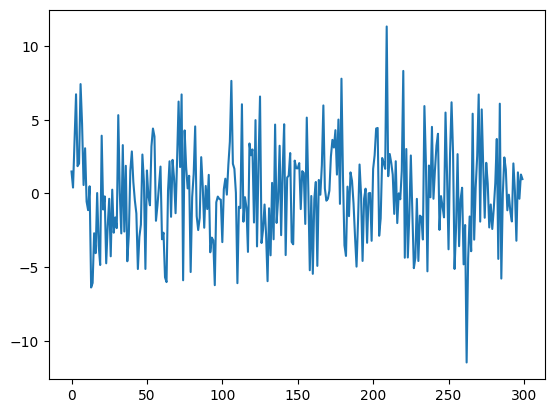

In [20]:
sample_paths = [path for path in sample_data_path.iterdir()]
sample_data = np.load(sample_paths[0])
plt.plot(sample_data[:300])

## Preprocessing

### Applying FFT

In [21]:
SAMPLING_RATE = 1000.0
DURATION = 5.0
N = SAMPLING_RATE * DURATION
MAX_FREQ = 100.0

In [24]:
def preprocess_file(filepath: Path) -> np.ndarray:
    # Load
    signal = np.load(filepath)

    # Checks
    assert signal.ndim == 1, "Signal must be 1D"
    assert len(signal) == int(N), "Unexpected signal length"

    # Remove DC offset
    signal = signal - np.mean(signal)

    # Windowing
    signal = signal * np.hanning(len(signal))

    # FFT
    fft_vals = np.fft.rfft(signal)
    mag = np.abs(fft_vals)

    freqs = np.fft.rfftfreq(len(signal), d=1.0 / SAMPLING_RATE)

    # Select frequency range 0–100 Hz
    mask = freqs <= MAX_FREQ
    mag = mag[mask]

    # Normalize magnitude to [0, 1]
    mag = mag / np.max(mag)

    return mag

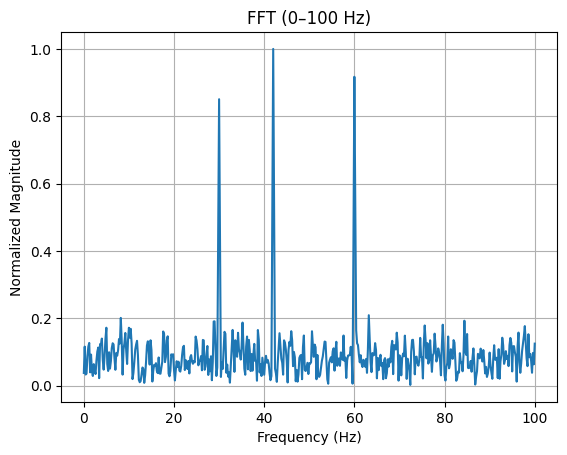

In [25]:
mag = preprocess_file(sample_paths[0])
freqs = np.linspace(0, 100, len(mag))

plt.plot(freqs, mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Magnitude")
plt.title("FFT (0–100 Hz)")
plt.grid(True)
plt.show()

In [27]:
def preprocess_dataset(
    input_root: Path,
    output_root: Path,
):
    for class_dir in input_root.iterdir():
        if not class_dir.is_dir():
            continue

        out_class_dir = output_root / class_dir.name
        out_class_dir.mkdir(parents=True, exist_ok=True)

        for filepath in class_dir.iterdir():
            if filepath.suffix != ".npy":
                continue

            mag = preprocess_file(filepath)

            out_path = out_class_dir / filepath.name
            np.save(out_path, mag)


In [28]:
process_dir = Path(Path(os.getcwd()).parent, 'data', 'processed')
preprocess_dataset(input_root=raw_dir, output_root=process_dir)

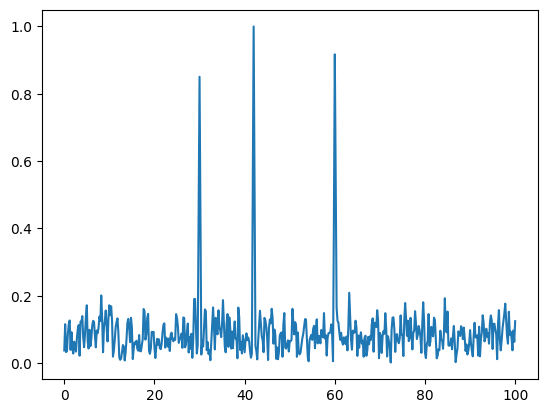

In [33]:
_dir = Path(Path(os.getcwd()).parent, 'data', 'processed', 'healthy')
samples_processed = [path for path in _dir.iterdir()]
sample_data = np.load(samples_processed[0])
freqs = np.linspace(0, 100, len(sample_data))
plt.plot(freqs, sample_data)